In [2]:
import pandas as pd
import zipfile
from datetime import datetime

In [3]:
#load zip file
zf = zipfile.ZipFile('data.zip') 

In [4]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [5]:
import numpy as np


def to_np(df, canvas_size=(70, 70), offset=1, labels=True,):

    H, W = canvas_size

    # 0. build wafer map & ground‑truth mask as numpy
    xy   = df[['DieX', 'DieY']].to_numpy(dtype=np.int16)
    good = df['IsGoodDie'].to_numpy(dtype=bool)

    wafer_np = np.zeros((H, W), np.float32)
    wafer_np[xy[good, 1] - offset, xy[good, 0] - offset] = 1.0
    wafer_np[xy[~good, 1] - offset, xy[~good, 0] - offset] = 0.0

    if labels:
      scratch = df['IsScratchDie'].to_numpy(dtype=bool)

      lbl = np.zeros_like(wafer_np)
      # Assign 1.0 to the coordinates where scratch is True
      lbl[xy[scratch, 1] - offset, xy[scratch, 0] - offset] = 1.0
    else:
      lbl = None

    return wafer_np, lbl

In [27]:

import cv2
import matplotlib.pyplot as plt
def show_wafer_edges(
    wafer_np: np.ndarray,
    lbl: np.ndarray,
    threshold: int = 90
):
    """
    Show wafer as color-coded image with:
    - Red = bad dies
    - Green = ground truth scratch
    - Blue = detected scratch contour
    """
    # --- Sobel detection ---
    sobelx = cv2.Sobel(wafer_np, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(wafer_np, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel_norm = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Apply threshold - set values below threshold to 0
    sobel_norm[sobel_norm < threshold] = 0.0

    # Normalize back to 0-1 after thresholding
    sobel_norm = sobel_norm.astype(np.float32) / 255.0
    # Show result
    
    plt.figure(figsize=(6, 6))
    plt.imshow(sobel_norm)
    plt.title("sobel")
    plt.show()
    plt.imshow(wafer_np)
    plt.title("wafer")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


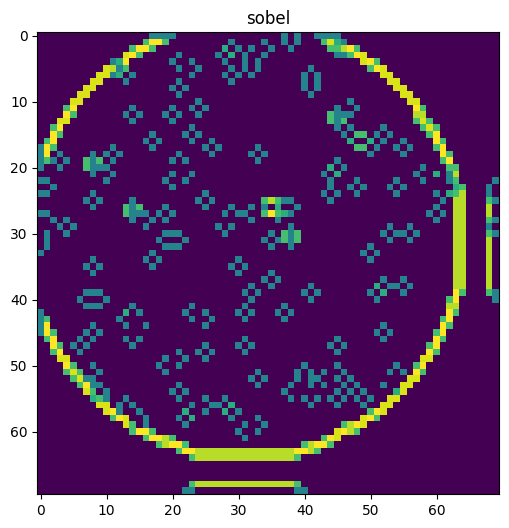

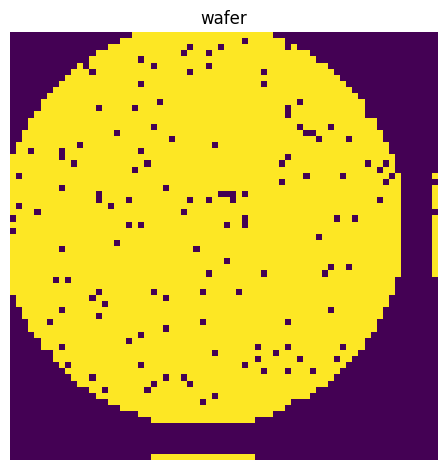

In [ ]:
import random
wafer_ids = df_wafers['WaferName'].unique()
n = random.randint(0, len(wafer_ids))
wafer_df = df_wafers.groupby('WaferName', sort=False).get_group(wafer_ids[n])
arr, lbl = to_np(wafer_df)
show_wafer_edges(arr, lbl, threshold=90)
